### Intro

In [1]:
!pip install trimesh
!pip install plotly
!pip install probreg
!pip install pycpd
# !pip install bcpd

     |████████████████████████████████| 641 kB 7.3 MB/s 
     |████████████████████████████████| 1.0 MB 7.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
     |████████████████████████████████| 408.6 MB 28 kB/s 
     |████████████████████████████████| 8.7 MB 49.5 MB/s 
     |████████████████████████████████| 4.3 MB 43.4 MB/s 
     |████████████████████████████████| 1.1 MB 52.2 MB/s 
     |████████████████████████████████| 596 kB 71.3 MB/s 
     |████████████████████████████████| 341 kB 49.8 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
     |████████████████████████████████| 428 kB 60.9 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 79 kB 8.2 MB/s 
     |█████████████████████

In [2]:
import numpy as np
import trimesh
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
import pandas as pd
from probreg import cpd
import copy
import matplotlib.pyplot as plt
from pycpd import DeformableRegistration, AffineRegistration
from functools import partial
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Functions

In [4]:
#https://github.com/ClayFlannigan/icp

def best_fit_transform(A, B):
    """
    Calculates the least-squares best-fit transform that maps corresponding points A to B in m spatial dimensions
    Input:
      A: Nxm numpy array of corresponding points
      B: Nxm numpy array of corresponding points
    Returns:
      T: (m+1)x(m+1) homogeneous transformation matrix that maps A on to B
      R: mxm rotation matrix
      t: mx1 translation vector
    """

    assert A.shape == B.shape

    # get number of dimensions
    m = A.shape[1]

    # translate points to their centroids
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    AA = A - centroid_A
    BB = B - centroid_B

    # rotation matrix
    H = np.dot(AA.T, BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
       Vt[m-1, :] *= -1
       R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_B.T - np.dot(R, centroid_A.T)

    # homogeneous transformation
    T = np.identity(m + 1)
    T[:m, :m] = R
    T[:m, m] = t

    return T, R, t

In [5]:
def nearest_neighbor(src, dst):
    """
    Find the nearest (Euclidean) neighbor in dst for each point in src
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        distances: Euclidean distances of the nearest neighbor
        indices: dst indices of the nearest neighbor
    """

    # assert src.shape == dst.shape

    neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
    neigh.fit(dst)
    distances, indices = neigh.kneighbors(src, return_distance=True)
    return distances.ravel(), indices.ravel()

In [6]:
def icp(src_tm: "<class 'trimesh'>", dst_tm: "<class 'trimesh'>",
        init_pose=None, max_iterations=20, tolerance=None, samplerate=1):
    """
    The Iterative Closest Point method: finds best-fit transform that maps points A on to points B
    Input:
        A: Nxm numpy array of source mD points
        B: Nxm numpy array of destination mD point
        init_pose: (m+1)x(m+1) homogeneous transformation
        max_iterations: exit algorithm after max_iterations
        tolerance: convergence criteria
        samplerate: subsampling rate
    Output:
        T: final homogeneous transformation that maps A on to B
        MeanError: list, report each iteration's distance mean error
    """

    # get vertices and their normals
    src_pts = np.array(src_tm.vertices)
    dst_pts = np.array(dst_tm.vertices)
    src_pt_normals = np.array(src_tm.vertex_normals)
    dst_pt_normals = np.array(dst_tm.vertex_normals)

    # subsampling
    ids = np.random.uniform(0, 1, size=src_pts.shape[0])
    A = src_pts[ids < samplerate, :]
    A_normals = src_pt_normals[ids < samplerate, :]
    ids = np.random.uniform(0, 1, size=dst_pts.shape[0])
    B = dst_pts[ids < 1, :]
    B_normals = dst_pt_normals[ids < 1, :]

    # get number of dimensions
    m = A.shape[1]

    # make points homogeneous, copy them to maintain the originals
    src = np.ones((m+1, A.shape[0]))
    dst = np.ones((m+1, B.shape[0]))
    src[:m, :] = np.copy(A.T)
    dst[:m, :] = np.copy(B.T)

    # apply the initial pose estimation
    if init_pose is not None:
        src = np.dot(init_pose, src)

    prev_error = 0
    MeanError = []

    for i in range(max_iterations):
        # find the nearest neighbors between the current source and destination points
        distances, indices = nearest_neighbor(src[:m, :].T, dst[:m, :].T)

        # match each point of source-set to closest point of destination-set,
        matched_src_pts = src[:m, :].T.copy()
        matched_dst_pts = dst[:m, indices].T

        # compute angle between 2 matched vertexs' normals
        matched_src_pt_normals = A_normals.copy()
        matched_dst_pt_normals = B_normals[indices, :]
        angles = np.zeros(matched_src_pt_normals.shape[0])
        for k in range(matched_src_pt_normals.shape[0]):
            v1 = matched_src_pt_normals[k, :]
            v2 = matched_dst_pt_normals[k, :]
            cos_angle = v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            angles[k] = np.arccos(cos_angle) / np.pi * 180

        # and reject the bad corresponding
        dist_threshold = np.inf # à changer 
        dist_bool_flag = (distances < dist_threshold)
        angle_threshold = 20
        angle_bool_flag = (angles < angle_threshold)
        reject_part_flag = dist_bool_flag * angle_bool_flag

        matched_src_pts = matched_src_pts[reject_part_flag, :]
        matched_dst_pts = matched_dst_pts[reject_part_flag, :]

        # compute the transformation between the current source and nearest destination points
        T, _, _ = best_fit_transform(matched_src_pts, matched_dst_pts)

        # update the current source
        src = np.dot(T, src)

        # print iteration
        print('\ricp iteration: %d/%d ...' % (i+1, max_iterations), end='', flush=True)

        # check error
        mean_error = np.mean(distances[reject_part_flag])
        MeanError.append(mean_error)
        if tolerance is not None:
            if np.abs(prev_error - mean_error) < tolerance:
                print('\nbreak iteration, the distance between two adjacent iterations '
                      'is lower than tolerance (%.f < %f)'
                      % (np.abs(prev_error - mean_error), tolerance))
                break
        prev_error = mean_error

    # calculate final transformation
    T, _, _ = best_fit_transform(A, src[:m, :].T)
    print()

    return T, MeanError

In [7]:
def pca_plotly_3d(init,recal):
    # Define layout
    layout = go.Layout(
        autosize=True,
        showlegend=True,
        title=f"Visualization of data with 3 components PCA ",
    )

    # Define figure
    fig = go.Figure(data=[go.Scatter3d(x=init.vertices[:, 2], y=init.vertices[:, 0], z=init.vertices[:, 1], mode='markers', marker=dict(
            size=1,
            color='red',
            opacity=0.6,
        )),go.Scatter3d(x=recal.vertices[:, 2], y=recal.vertices[:, 0], z=recal.vertices[:, 1], mode='markers', marker=dict(
            size=1,
            color='blue',
            opacity=0.6,
        ))],     
        layout=layout,
    )

    # Plot figure    
    fig.show()

In [8]:
def plotly_3d(*points_clouds):
    # Define layout
    layout = go.Layout(
        autosize=True,
        showlegend=True,
        title=f"Visualization of {len(points_clouds)} points clouds.",
    )

    # Define data
    data = [go.Scatter3d(x=p[:,2], y=p[:,0], z=p[:,1], mode='markers', marker=dict(size=1,opacity=0.6,))
            for p in points_clouds]

    # Define figure
    fig = go.Figure(data=data,layout=layout)

    # Plot figure    
    fig.show()

### Application

#### ICP

In [9]:
%cd /content/drive/MyDrive/Projet_A3S5/Donnees

/content/drive/.shortcut-targets-by-id/1VyeGE8G8NemjPGnlHQA2fEjmVxwDsQTS/Projet_A3S5/Donnees


In [13]:
nbr = 22

recal_mesh = trimesh.load('/content/drive/MyDrive/Projet_A3S5/Donnees/Final_Data/Femur/OBJ/5000/Femur_64_5000.obj')
init_mesh = trimesh.load('/content/drive/MyDrive/Projet_A3S5/Donnees/Final_Data/Femur/OBJ/5000/Femur_65_5000.obj')

print(len(np.asarray(init_mesh.vertices)))
print(len(np.asarray(recal_mesh.vertices)))

# ICP
H, ME = icp(recal_mesh, init_mesh, max_iterations=15)
res_tm = recal_mesh.copy()
res_tm.apply_transform(H)

14867
14805
icp iteration: 15/15 ...


<trimesh.Trimesh(vertices.shape=(14805, 3), faces.shape=(4998, 3))>

In [14]:
# Before icp
plotly_3d(np.asarray(init_mesh.vertices),np.asarray(recal_mesh.vertices))

In [15]:
# After icp
plotly_3d(np.asarray(init_mesh.vertices),np.asarray(res_tm.vertices))

1.9628352637040154


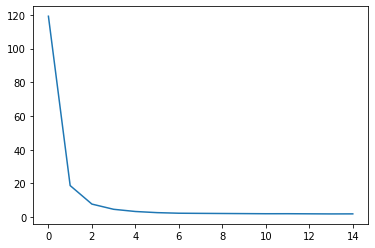

In [16]:
print(ME[-1])
plt.plot(ME)
plt.show()

#### CPD (Coherent Point Drift)


In [17]:
init_point_cloud = np.asarray(init_mesh.vertices)
res_point_cloud = np.asarray(res_tm.vertices)
print(len(res_point_cloud))
print(len(init_point_cloud))

14805
14867


In [ ]:
# compute cpd registration
tf_param, _, _ = cpd.registration_cpd(init_point_cloud[:14805], res_point_cloud, tf_type_name="nonrigid", beta = 100, lmd = 0.01, maxiter=2000) 
result = copy.deepcopy(res_point_cloud)

In [ ]:
print(len(result))

14805


In [ ]:
# CPD Result
res = o3d.geometry.PointCloud()
res.points = o3d.utility.Vector3dVector(result)
res.points = tf_param.transform(res.points)

# Initial
init = o3d.geometry.PointCloud()
init.points = o3d.utility.Vector3dVector(init_point_cloud[:14805])

# ICP Result
res_rigid = o3d.geometry.PointCloud()
res_rigid.points = o3d.utility.Vector3dVector(np.asarray(res_tm.vertices))

In [ ]:
init_array = np.asarray(init.points)
res_array = np.asarray(res.points)
res_rigid_array = np.asarray(res_rigid.points)

In [ ]:
plotly_3d(init_array, res_array)

In [ ]:
distances, indices = nearest_neighbor(init_array, res_array)
mean_error = np.mean(distances)
print(mean_error)

2.8129615779256305
